# Output Normalized Data
Script to normalize CESM data and limit to sub-region 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import scipy

from tqdm import tqdm

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [43]:
# User Edits

resolution = "full" # Resolution of the data "2deg" or "full"
variables  = ["sst","sss","psl"] # Variables to normalize
bbox       = [-80,0,0,65] # Bounding box [lonW, lonE, latS, latN]
region     = "NAT" # Specify the region name
debug      = True # Set to true to show visualizations
month_id   = np.arange(0,12,1)# indices of months to average over 
# selmon examples (N.H.)
# Annual = np.arange(0,12,1)
# Winter = [-1,0,1]
# Spring = [2,3,4]
# Summer = [5,6,7]
# Fall   = [8,9,10]

In [42]:
# Functions
def deseason_lazy(ds,return_scycle=False):
    """
    Deseason function without reading out the values. Remove the seasonal cycle by subtracting the monthly anomalies
    Input:
        ds : DataArray
            Data to be deseasoned
        return_scycle : BOOL (Optional)
            Set to true to return the seasonal cycle that was removed
    Output:
        data_deseason : DataArray
            Deseasoned data
    
    """
    data_deseason = ds.groupby('time.month') - ds.groupby('time.month').mean('time')
    
    if return_scycle:
        return data_deseason,ds.groupby('time.month').mean('time')
    return data_deseason


def deseason(ds):
    """
    Original deseason function
    
    Remove the seasonal cycle by subtracting the monthly anomalies.
    Loads data from dataarray and Sets NaN values to zero
    
    Input:
        ds : DataArray
    Output:
        data_deseason : Numpy Array
    
    """
    data = ds.T.values
    
    monthly_means = np.zeros((42,86,12,89,33))
    
    iyr = 0
    for it in range(1032):
        mo_ind = it%12
        monthly_means[:,iyr,mo_ind,:,:] = data[:,it,:,:]
        if mo_ind==11:
            iyr+=1
    monthly_means = np.nanmean(monthly_means,axis=1)
    
    data_deseason = np.zeros(data.shape)
    for it in range(1032):
        mo_ind = it%12
        data_deseason[:,it,:,:] = data[:,it,:,:] - monthly_means[:,mo_ind,:,:]

    data_deseason[np.isnan(data_deseason)] = 0
    return data_deseason

def deseason_detrend(ds):
    data = ds.T.values
    monthly_means = np.zeros((42,86,12,89,33))
    
    iyr = 0
    for it in range(1032):
        mo_ind = it%12
        monthly_means[:,iyr,mo_ind,:,:] = data[:,it,:,:]
        if mo_ind==11:
            iyr+=1
    monthly_means = np.nanmean(monthly_means,axis=1)
    
    data_deseason = np.zeros(data.shape)
    for it in range(1032):
        mo_ind = it%12
        data_deseason[:,it,:,:] = data[:,it,:,:] - monthly_means[:,mo_ind,:,:]
    
    data_detrend = data_deseason - np.nanmean( data_deseason, axis=0 )
    data_detrend[np.isnan(data_detrend)] = 0
    return data_detrend

# Preprocessing Function
def preprocess(vname,resolution,bbox,month_id):
    """
    Preprocess CESM Data with the following steps:
        1) Load dataset from netCDF
        2) Crop to selected region
        3) Apply Latitude weights
        4) Remove Seasonal Cycle
        5) Load the data to numpy array
        6) Average over selected months for annual resolution
        7) Normalize values and Fill NaNs with zeros
        8) Permute dimensions to [ensemble x time x lat x lon]
    
    Inputs
    ------
        1. vname : STR
            Name of the variable [ex: "sst","sss","psl","NHFLX"]
        2. resolution : STR
            Resolution of the data "2deg" or "full"
        3. bbox : ARRAY
            Bounding box to crop to [lonW, lonE, latS, latN]
        4. month_idx : ARRAY
            Indices of months to average over
                Annual = np.arange(0,12,1)
                Winter = [-1,0,1]
                Spring = [2,3,4]
                Summer = [5,6,7]
                Fall   = [8,9,10]
    
    Output
    ------
        ds_normed : ARRAY
            Processed data, [ensemble x time x lat x lon]
    
    Dependencies
    ------------
        import xarray as xr
        import numpy as np
        "deseason_lazy" function from amvmod
    
    """

    # 1) Open dataset
    if resolution == '2deg':
        ds = xr.open_dataset("../../CESM_data/CESM1LE_%s_NAtl_19200101_20051201_Regridded2deg.nc"% (vname))[vname]
    elif resolution == 'full':
        ds = xr.open_dataset("../../CESM_data/CESM1LE_%s_NAtl_19200101_20051201.nc"% (vname))[vname]
    else:
        print("Error: Pleae input either '2deg' or 'full' for resolution")
     
    # 2) Select Region
    dsreg = ds.sel(lon=slice(bbox[0],bbox[1]),lat=slice(bbox[2],bbox[3]))
    
    # 3) Apply latitude weights
    dswgt = np.cos(dsreg.lat*np.pi/180) * dsreg
    
    # 4) Deseason the data
    data_deseason,scycle = deseason_lazy(dswgt,return_scycle=True)
    
    # 5) Read out the data
    dsout = data_deseason.values # [Lat x Lon x Time x Ensemble]
    
    # 6) Select months and take the average (for annual resolution)
    nlat,nlon,ntime,nens = dsout.shape
    dsout = dsout.reshape(nlat,nlon,int(ntime/12),12,nens)
    dsout = dsout[:,:,:,month_id,:].mean(3) 
    
    # 7) Normalize values and fill NaNs with zeros
    ds_normed = (dsout - np.nanmean(dsout))/np.nanstd(dsout)
    ds_normed[np.isnan(ds_normed)] = 0
    
    # Permute from [lat x lon x time x ens] to [ens x time x lat x lon]
    ds_normed = ds_normed.transpose(3,2,0,1)
    
    return ds_normed
    

  0%|          | 0/3 [00:00<?, ?it/s]

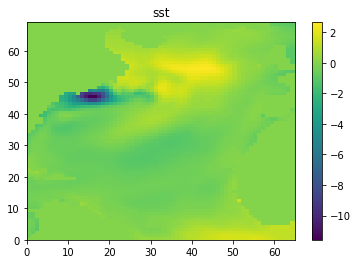

 33%|███▎      | 1/3 [00:13<00:26, 13.05s/it]

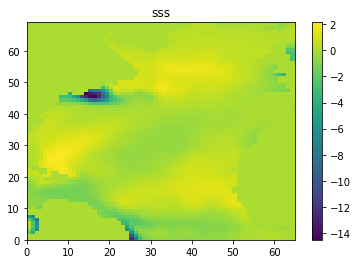

 67%|██████▋   | 2/3 [00:29<00:14, 14.21s/it]

In [ ]:
# Loop for each variable
for v in tqdm(range(len(variables))):
    
    vname = variables[v]
    
    vproc = preprocess(vname,resolution,bbox,month_id)
    
    if debug:
        plt.pcolormesh(vproc[0,0,:,:]),plt.colorbar(),plt.title(vname),plt.show()
    
    np.save("../../CESM_data/CESM_%s_normalized_lat_weighted_%s_%s.npy"%(vname,resolution,region),vproc)
    

# Section below contains the original script/functions and testing

In [48]:
import os
os.getcwd()

'/Users/gliu/Downloads/2020_Fall/6.862/Project/predict_amv/Preprocessing'

In [21]:
# Loop to process data

vname = variables[0]

# Open dataset
if resolution == '2deg':
    ds = xr.open_dataset("../../CESM_data/CESM1LE_%s_NAtl_19200101_20051201_Regridded2deg.nc"% (vname))[vname]
elif resolution == 'full':
    ds = xr.open_dataset("../../CESM_data/CESM1LE_%s_NAtl_19200101_20051201.nc"% (vname))[vname]
else:
    print("Error: Pleae input either '2deg' or 'full' for resolution")

# Lat x Lon x Time x Ensemble
ds

<xarray.DataArray 'sst' (lat: 96, lon: 89, time: 1032, ensemble: 42)>
[370331136 values with dtype=float32]
Coordinates:
  * lat       (lat) float64 0.4712 1.414 2.356 3.298 ... 87.17 88.12 89.06 90.0
  * lon       (lon) float64 -90.0 -88.75 -87.5 -86.25 ... 16.25 17.5 18.75 20.0
  * time      (time) object 1920-01-01 00:00:00 ... 2005-12-01 00:00:00
  * ensemble  (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 34 35 36 37 38 39 40 41 42

In [22]:
# Select Region
dsreg = ds.sel(lon=slice(bbox[0],bbox[1]),lat=slice(bbox[2],bbox[3]))
dsreg 

<xarray.DataArray 'sst' (lat: 69, lon: 65, time: 1032, ensemble: 42)>
[194397840 values with dtype=float32]
Coordinates:
  * lat       (lat) float64 0.4712 1.414 2.356 3.298 ... 61.73 62.67 63.61 64.55
  * lon       (lon) float64 -80.0 -78.75 -77.5 -76.25 ... -3.75 -2.5 -1.25 0.0
  * time      (time) object 1920-01-01 00:00:00 ... 2005-12-01 00:00:00
  * ensemble  (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 34 35 36 37 38 39 40 41 42

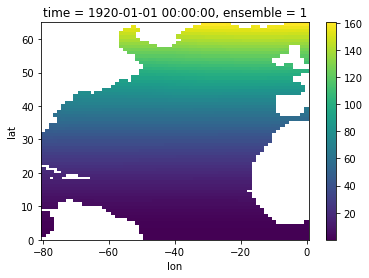

In [23]:
# Apply latitude weights
dswgt = np.cos(dsreg.lat*np.pi/180) * dsreg

if debug:
    diff = dsreg-dswgt
    diff.isel(time=0,ensemble=0).plot()

In [24]:
# Deseason the data
data_deseason,scycle = deseason_lazy(dswgt,return_scycle=True)

data_deseason,scycle

(<xarray.DataArray (lat: 69, lon: 65, time: 1032, ensemble: 42)>
 array([[[[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          ...,
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]],
 
         [[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
       

In [33]:
%%time
# Read out the data
dsout = data_deseason.values # [Lat x Lon x Time x Ensemble]


dsout 

CPU times: user 253 µs, sys: 17.4 ms, total: 17.6 ms
Wall time: 17.6 ms


array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e

In [34]:
# Select months and take average

nlat,nlon,ntime,nens = dsout.shape
dsout = dsout.reshape(nlat,nlon,int(ntime/12),12,nens)
dsout = dsout[:,:,:,month_id,:].mean(3) 

dsout.shape




(69, 65, 86, 42)

CPU times: user 2.61 s, sys: 968 ms, total: 3.58 s
Wall time: 3.58 s


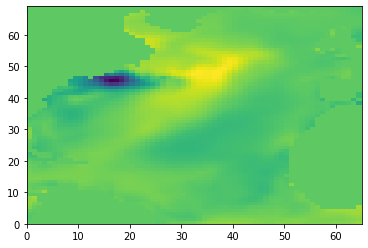

In [28]:
%%time
# Normalize values
ds_normed = (dsout - np.nanmean(dsout))/np.nanstd(dsout)
ds_normed[np.isnan(ds_normed)] = 0

if debug:
    plt.pcolormesh(dsout[:,:,0,0])

In [29]:
# Permute from [lat x lon x time x ens] to [ens x time x lat x lon]
ds_normed = ds_normed.transpose(3,2,0,1)
ds_normed.shape

(42, 1032, 69, 65)

In [3]:


#ds_moc = xr.open_dataset("../CESM_data/CESM1LE_MOC_NAtl_20N-50N_19200101_20051201.nc")

ds_sst = xr.open_dataset("../../CESM_data/CESM1LE_sst_NAtl_19200101_20051201.nc")['sst'][21:54,:,:,:]
#ds_FLNS = xr.open_dataset("../CESM_data/CESM1LE_FLNS_NAtl_19200101_20051201.nc")['FLNS'][21:54,0:89,:,:]
#ds_FSNS = xr.open_dataset("../CESM_data/CESM1LE_FSNS_NAtl_19200101_20051201.nc")['FSNS'][21:54,0:89,:,:]
#ds_LHFLX = xr.open_dataset("../CESM_data/CESM1LE_LHFLX_NAtl_19200101_20051201.nc")['LHFLX'][21:54,0:89,:,:]
#ds_NHFLX = xr.open_dataset("../CESM_data/CESM1LE_NHFLX_NAtl_19200101_20051201.nc")['NHFLX'][21:54,0:89,:,:]
#ds_SHFLX = xr.open_dataset("../CESM_data/CESM1LE_SHFLX_NAtl_19200101_20051201.nc")['SHFLX'][21:54,0:89,:,:]
ds_sss = xr.open_dataset("../../CESM_data/CESM1LE_sss_NAtl_19200101_20051201.nc")['sss'][21:54,0:89,:,:]
ds_psl = xr.open_dataset("../../CESM_data/CESM1LE_psl_NAtl_19200101_20051201.nc")['psl'][21:54,0:89,:,:]

In [4]:
# Apply Latitude Weights (Cosine of Latitude)
lat_weighted_sst = np.cos(ds_sst.lat*np.pi/180) * ds_sst
lat_weighted_sss = np.cos(ds_sss.lat*np.pi/180) * ds_sss
lat_weighted_psl = np.cos(ds_psl.lat*np.pi/180) * ds_psl

In [5]:
xr.open_dataset("../../CESM_data/CESM1LE_psl_NAtl_19200101_20051201.nc")['psl']

<xarray.DataArray 'psl' (lat: 96, lon: 105, time: 1032, ensemble: 42)>
[436907520 values with dtype=float32]
Coordinates:
  * lat       (lat) float64 0.4712 1.414 2.356 3.298 ... 87.17 88.12 89.06 90.0
  * lon       (lon) float64 -90.0 -88.75 -87.5 -86.25 ... 36.25 37.5 38.75 40.0
  * time      (time) object 1920-01-01 00:00:00 ... 2005-12-01 00:00:00
  * ensemble  (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 34 35 36 37 38 39 40 41 42

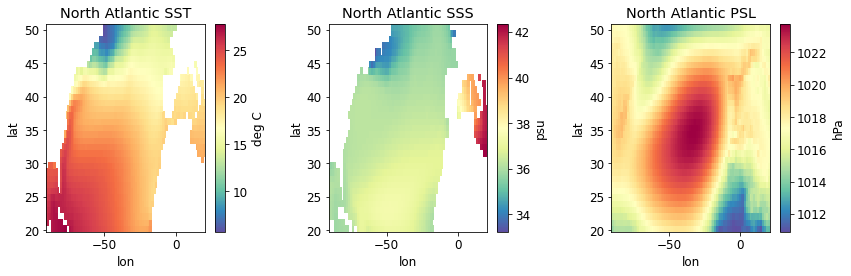

In [35]:
plt.figure(figsize=(12,4))
plt.rcParams.update({'font.size': 12})

plt.subplot(131)
(ds_sst.mean(dim=('time','ensemble'))-273.15).plot(cmap='Spectral_r',cbar_kwargs={'label': 'deg C'})
plt.title('North Atlantic SST')

plt.subplot(132)
(ds_sss.mean(dim=('time','ensemble'))).plot(cmap='Spectral_r',cbar_kwargs={'label': 'psu'})
plt.title('North Atlantic SSS')

plt.subplot(133)
(ds_psl.mean(dim=('time','ensemble'))/100).plot(cmap='Spectral_r',cbar_kwargs={'label': 'hPa'})
plt.title('North Atlantic PSL')

plt.tight_layout()

plt.savefig('../Figures/SST_SSS_PSL_climatology.jpg', dpi=300)
plt.show()

In [16]:
#%%time
sst_deseasoned = deseason(lat_weighted_sst)
sss_deseasoned = deseason(lat_weighted_sss)
psl_deseasoned = deseason(lat_weighted_psl)

<ipython-input-36-7d8a38611413>:11: RuntimeWarning: Mean of empty slice
  monthly_means = np.nanmean(monthly_means,axis=1)


CPU times: user 12.5 s, sys: 2.73 s, total: 15.2 s
Wall time: 15.3 s


In [17]:
#%%time6
sst_normed = (sst_deseasoned - np.mean(sst_deseasoned))/np.std(sst_deseasoned)
sss_normed = (sss_deseasoned - np.mean(sss_deseasoned))/np.std(sss_deseasoned)
psl_normed = (psl_deseasoned - np.mean(psl_deseasoned))/np.std(psl_deseasoned)

In [39]:
plt.figure(figsize=(12,3))
plt.rcParams.update({'font.size': 12})

plt.plot(np.mean(sst_normed,axis=(0,2,3)))
plt.plot(np.mean(sss_normed,axis=(0,2,3)))
plt.plot(np.mean(psl_normed,axis=(0,2,3)))
plt.legend(['sst','sss','psl'])

NameError: name 'sst_normed' is not defined

<Figure size 864x216 with 0 Axes>

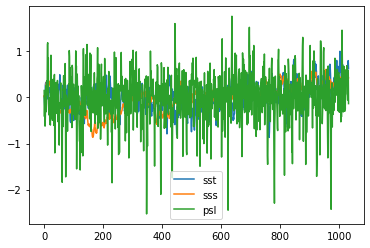

In [19]:
plt.plot(np.mean(sst_normed,axis=(2,3))[30,:])
plt.plot(np.mean(sss_normed,axis=(2,3))[30,:])
plt.plot(np.mean(psl_normed,axis=(2,3))[30,:])
plt.legend(['sst','sss','psl'])

In [20]:
sst_normed.shape

(42, 1032, 89, 33)

In [21]:
np.save("../CESM_data/CESM_SST_normalized_lat_weighted.npy",sst_normed)

In [22]:
np.save("../CESM_data/CESM_SSS_normalized_lat_weighted.npy",sss_normed)

In [23]:
np.save("../CESM_data/CESM_PSL_normalized_lat_weighted.npy",psl_normed)

In [16]:
.08*.29

0.0232/0.5

0.0464

In [15]:
np.nanmax(sst_deseasoned)

4.136080444760694

In [ ]:
data_deseason = ds - ds.groupby('time.month').mean('time')

